### Upgrade pip

(The previous intern had this, not 100% sure when it's needed)

In [1]:
%pip install --upgrade pip 

Note: you may need to restart the kernel to use updated packages.


### Format the Google BigQuery query

It's strongly recommendeded that you first test your query in Google's BigQuery Sandbox (online). It returns results ~100 times faster, will yell at you pre-runtime if you introduce syntax errors, and it also shows a preview of expected data usage for the given query.

TODO: extend query to include Oct/Nov/Dec 2021, not just 2022+

In [58]:
QUERY = """
SELECT
  q.id,
  q.title,
  q.body,
  q.accepted_answer_id,
  q.view_count,
  q.tags,
  q.answer_count,
  q.score AS question_score,
  a.score AS answer_score,
  a.body AS stackoverflow_answer
FROM
  bigquery-public-data.stackoverflow.posts_questions q
LEFT JOIN
  bigquery-public-data.stackoverflow.posts_answers a
ON
  q.accepted_answer_id = a.id
WHERE
  q.answer_count > 0
  AND q.accepted_answer_id > 0
  AND EXTRACT(YEAR FROM q.creation_date) >= 2022
  AND a.score >= 0
"""

### Fetch dataset using Google BigQuery

Authentication info: https://googleapis.dev/python/google-api-core/latest/auth.html (the query will fail if you don't set up authentication first).

To use server-side sampling with BigQuery (culls data server-side, reducing download size), use `TABLESAMPLE SYSTEM` e.g.:

`bigquery-public-data.stackoverflow.posts_questions q TABLESAMPLE SYSTEM (10 PERCENT)`

`bigquery-public-data.stackoverflow.posts_answers a TABLESAMPLE SYSTEM (50 PERCENT)`

(be aware that using less than 100% for both of questions and answers can result in no matches between the two if unlucky with rng, causing the query to return no results)

In [59]:
%pip install google-cloud-bigquery
%pip install db-dtypes
import db_dtypes
import json
import os
import pandas as pd
from pathlib import Path
from google.cloud import bigquery as bq

# get project name from local secrets.json file
def load_project_ID(secrets_file="secrets.json"):
    with open(secrets_file) as f:
        secrets = json.load(f)
    return secrets["BQ_PROJECT_ID"]

# load a saved copy of the dataset from local disk (if it exists), otherwise run query and save it
PICKLED_RESULT = "dataset_pickled.pkl"  # the file name of the saved dataset (saved on / loaded from local disk)
cwd = Path().absolute()                 # current working directory (note: possibly different from execution directory)

# see if we have a copy of the dataset on local disk; if we do load that
try:
    dataset_path = os.path.join(cwd, PICKLED_RESULT)
    results = pd.read_pickle(dataset_path)
    print("Saved copy of dataset loaded from local disk.")

# if not, run the query (tested runtime was up to 1 hour for full query!)
except FileNotFoundError:
    print("Saved copy of dataset (" + PICKLED_RESULT + ") not found - running query...")

    # prepare query
    client = bq.Client(project=load_project_ID())

    # run the query and save result to a dataframe
    results = client.query(QUERY.format(offset=0)).result().to_dataframe()
    print("Dataset has been downloaded...")

    # pickle the dataframe for persistent copy on local storage
    results.to_pickle(PICKLED_RESULT)
    print("Dataset has been pickled and saved to local storage. File name: " + PICKLED_RESULT)

# yell if there's an *unexpected* error
except:
    raise Exception("Error while loading dataset.")

# dump some extra info
print("Number of questions:", len(results))
results.head()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Saved copy of dataset loaded from local disk.
Number of questions: 383845


,id,title,body,accepted_answer_id,view_count,tags,answer_count,question_score,answer_score,stackoverflow_answer
0,73688486,"Android Studio Error ""requires libraries and a...",<p>All librabries are updated.</p>\n<p><strong...,73688665,1342,android|xml|kotlin|gradle|mobile,2,7,7,<p><strong>There are 2 ways to fix this error:...
1,70601508,Can I use Java 16 record with JPA entity?,<p>I am trying to do something similar like be...,70601646,2096,java|spring-boot|jpa|spring-data-jpa,1,7,9,"<p>See the article, <a href=""https://wkorando...."
2,72056470,streamWriter does not apply changes until I re...,<p>I'm making a game in Unity with an editor l...,72056589,49,c#|unity3d|streamwriter,1,2,6,<p>You just need to refresh the assets in Unit...
3,72336177,Error: req#logout requires a callback function,<p>can't able to find solution of this tried e...,72336399,13559,javascript|express|passport.js|google-authenti...,6,30,64,<p>Since version 0.6.0 (which was released onl...
4,71941928,How to transfer ERC20 tokens to another addres...,"<p>I create ERC20 tokens, and i want to transf...",71943184,3360,solidity|polygon|erc20,1,1,8,<p>Your logic is wrong!\nIf you want to send a...


### Cull / filter dataset

For the demo we're just arbitrarily culling the size of the dataset to make it more manageable, but you could also filter for other reasons such as focusing on a specific tag, or sampling based on answer and/or question scores.

A pandas dataframe can be sampled either:
* Using a fractional value: e.g., ``.sample(frac=0.01)`` will result in a number of samples equivalent to 1% of the dataset.
* Using an integer value: e.g., ``.sample(n=1000)`` will result in 1000 samples from the dataset.

In [60]:
# randomly sample dataset
fd_tiny = results.sample(frac=0.0001)       # used for testing / demo (intentionally small)
fd_1k   = results.sample(n=1000)            # used if/when verifying tests on a larger sample
fd_10k  = results.sample(n=10000)           # used if/when verifying tests on an even larger sample

# convenience: alias the filtered data so we can change it easily for later code
wd = fd_tiny

# dump info about the filtered result
print("Number of questions in currently selected filtered dataset:", len(wd))
wd.head()

Number of questions in currently selected filtered dataset: 38


,id,title,body,accepted_answer_id,view_count,tags,answer_count,question_score,answer_score,stackoverflow_answer
156411,72746948,subsampling formula skipgram NLP,<p>I'm studying how to implement a Skip-Gram m...,72747728,17,nlp|word2vec|subsampling,1,0,0,<p>The frequent-word downsampling option ('sub...
173991,72912192,Drop ALL rows in pandas until a specific strin...,<p>I have a dataframe and I want to delete eve...,72913144,40,python|pandas,2,1,1,<p>Why don't you find the first index where th...
98981,72743315,How to display three columns in each row?,"<p>I have built the project, but I can't displ...",72747848,61,css|vue.js|vuejs2|nuxt.js,2,2,1,<p>Something like this will handle 3 different...
167601,70946936,How to move text from old column to newly crea...,<p>I want to move around description text colu...,70947124,50,python|pandas|dataframe,3,0,1,<p>Here is a simple way using a regex with nam...
284318,70868246,"While using a dialogflow mega-agent, according...","<p>While using a dialogflow mega-agent, accord...",71004011,84,node.js|dialogflow-es,1,0,1,<p>To specify one or more sub-agents for a det...


### Dataset analysis

In [7]:
import numpy as np

def get_basic_analysis(data_col):
    avg = np.mean(data_col)
    max = np.max(data_col)
    min = np.min(data_col)
    med = np.median(data_col)
    return avg, max, min, med

def print_basic_analysis(data_col, label):
    avg, max, min, med = get_basic_analysis(data_col)
    print("Stats for " + label + ":" )
    print("Average: " + f"{avg:,.2f}")
    print("Maximum: " + f"{max:,}")
    print("Minimum: " + str(min))
    print("Median: "  + str(med))
    print()

In [26]:
print_basic_analysis(results['view_count'], "view count")
print_basic_analysis(results['answer_count'], "answer count")
print_basic_analysis(results['question_score'], "question score")
print_basic_analysis(results['answer_score'], "answer score")

Stats for view count:
Average: 187.75
Maximum: 154,191
Minimum: 3
Median: 66.0

Stats for answer count:
Average: 1.38
Maximum: 31
Minimum: 1
Median: 1.0

Stats for question score:
Average: 0.44
Maximum: 318
Minimum: -14
Median: 0.0

Stats for answer score:
Average: 1.17
Maximum: 315
Minimum: 0
Median: 1.0



In [61]:
%pip install seaborn
import seaborn
#from matplotlib.ticker import ScalarFormatter
import matplotlib
from matplotlib.ticker import StrMethodFormatter
import math

# Temporarily override the figuresize using rc params
matplotlib.rcParams["figure.figsize"] = (8, 2)

def five_num_box(data, x_label):
    ax = seaborn.boxplot(data=data, orient="h", whis=math.inf)          # prevents unwanted outlier detection
    ax.set(xlabel=x_label)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    #ax.get_figure().savefig("Temp\\" + x_label + ".png")

def five_num_box_log(data, x_label):
    ax = seaborn.boxplot(data=data, orient="h", whis=math.inf)          # prevents unwanted outlier detection
    ax.set(xlabel=x_label)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))        # https://stackoverflow.com/a/46574866
    #ax.get_figure().savefig("Temp\\" + x_label + ".png")

def convertFiveFormat(series):
    listified = []
    listified.append(series["min"])
    listified.append(series["25%"])
    listified.append(series["50%"])
    listified.append(series["75%"])
    listified.append(series["max"])
    return listified

five_vc = results.view_count.describe()
five_ac = results.answer_count.describe()
five_qs = results.question_score.describe()
five_as = results.answer_score.describe()

Note: you may need to restart the kernel to use updated packages.


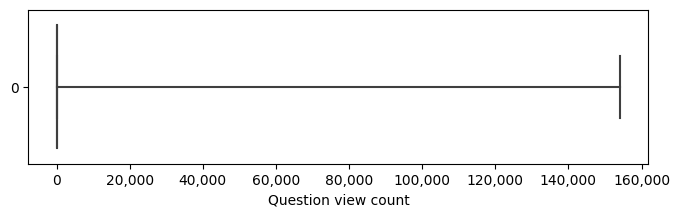

In [30]:
five_num_box(convertFiveFormat(five_vc), "Question view count")

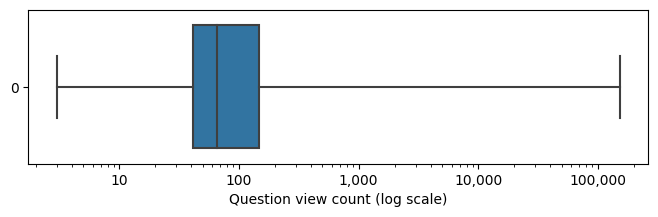

In [31]:
five_num_box_log(convertFiveFormat(five_vc), "Question view count (log scale)")

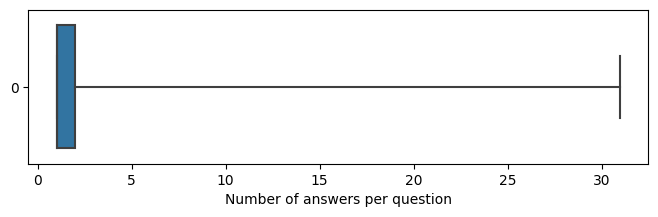

In [32]:
five_num_box(convertFiveFormat(five_ac), "Number of answers per question")

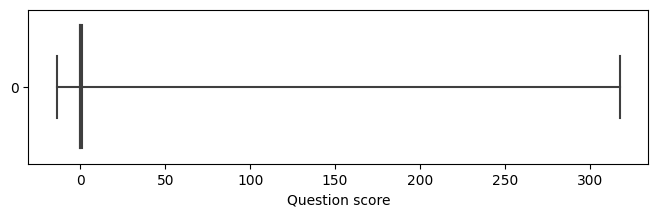

In [33]:
five_num_box(convertFiveFormat(five_qs), "Question score")

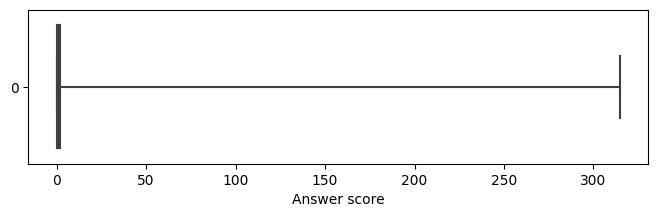

In [34]:
five_num_box(convertFiveFormat(five_as), "Answer score")

In [35]:
from collections import Counter

COUNT_RESULT = "tag_count.csv"  # the file name of the saved dataset (saved on / loaded from local disk)

# See if we already have a saved copy of the tag counting
try:
    count_path = os.path.join(cwd, COUNT_RESULT)
    count = pd.read_csv(count_path)
    print("Saved copy of tag count loaded from local disk.")

# If not, run the count (tested runtime on 9750-H was about an hour for full dataset!)
except FileNotFoundError:
    print("Saved copy of tag count (" + COUNT_RESULT + ") not found - running count...")

    # Run the counter
    count = pd.Series(wd["tags"].str.split('|').map(Counter).sum())
    print("Tag counting completed.")

    # Save the result to a CSV
    count.to_csv(COUNT_RESULT)
    print("Tag count has been saved to local storage as a CSV: " + count_path)

Saved copy of tag count loaded from local disk.


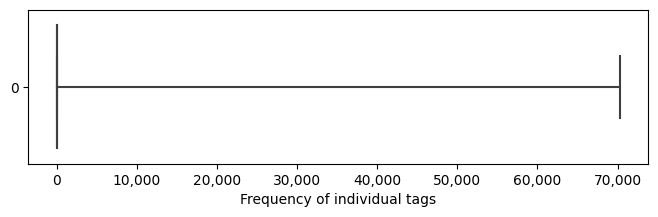

In [62]:
s = count.iloc[:,1]

temp = convertFiveFormat(s.describe())
five_num_box(temp, "Frequency of individual tags")

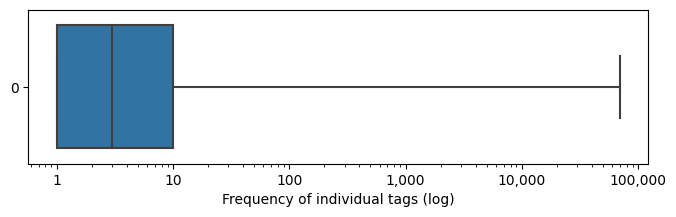

In [63]:
five_num_box_log(temp, "Frequency of individual tags (log)")

In [64]:
# Reset rc params
matplotlib.rc_file_defaults()

### Strip HTML from filtered dataset

We decided we would strip HTML and use this "stripped" version as our default for evaluations.

TODO: save stripped version into a new column in the dataframe, instead of immediately throwing it into JSON

In [ ]:
# from bs4 import BeautifulSoup as soup

# # Separate out the text columns we want for convenience
# titles  = wd["title"]
# bodies  = wd["body"]
# answers = wd["stackoverflow_answer"]

# # Debugging: preview the formatting currently being used pre-strip
# # print("Pre-stripped questions:\n========================")
# # for answer in bodies:
# #     print(answer)

# # Sanity check (surely this will always be true,  but *just in case*)
# if len(titles) == len(bodies) and len(titles) == len(answers):
#     pass
# else:
#     raise ValueError("columns are different lengths!")

# # Debugging
# # print("Post-stripped example questions:\n========================")
# # counter_good = 0
# # counter_bad = 0

# # Create an empty list to store all our JSON
# json_list = []

# # Iiterating is slow(!) but comparatively easy to understand (modified Harvey approach)
# for idx, *row in wd.itertuples():
#     #print("::::::::::::::::::::::::::::::::::::", str(idx))        # Debugging
#     try:
#         question_composite = titles[idx] + "\n\n" + (soup(bodies[idx], "html.parser").get_text())

#         # Debugging
#         #print(question_composite)
#         #print(soup(bodies[i], "html.parser").get_text())
#         #counter_good += 1

#         stackoverflow_ans = (soup(answers[idx], "html.parser").get_text())

#         # new 2023-08-24: checking quote escaping (TODO: remove?)
#         #question_composite = question_composite.replace('"', '\\\"')
#         #stackoverflow_ans = stackoverflow_ans.replace('"', '\\\"')

#         json_object = {
#             "input": question_composite,
#             "ideal": stackoverflow_ans
#         }

#         # Debugging
#         #print(json_object)

#         json_list.append(json.dumps(json_object))

#     # debugging bad entries (if everything goes smoothly this will never run)
#     except:
#         counter_bad += 1
#         print("check:", str(idx))
#         try:
#             print(titles[idx])
#         except:
#             continue

#         try:
#             print(bodies[idx])
#         except:
#             continue

#         try:
#             print(answers[idx])
#         except:
#             continue

# # because re-running the notebook changes the sampling we DON'T want a persistent jsonl file
# JSONL_FILENAME = "new_samples.jsonl"
# JSONL_FILEPATH = os.path.join(cwd, "temp", JSONL_FILENAME)
# with open(JSONL_FILEPATH, "w") as outfile:
#     outfile.write("\n".join(json_list))
#     print("Saved JSONL file: " + JSONL_FILEPATH)

TODO: remove/clean up

NOTE: the top version is the old one one with the probably-not-needed debugging lines still in place (but commented out).

The bottom one is cleaned up to remove all of that.

In [ ]:
from bs4 import BeautifulSoup as soup

# Separate out the text columns we want for convenience
titles  = wd["title"]
bodies  = wd["body"]
answers = wd["stackoverflow_answer"]

# Sanity check (surely this will always be true,  but *just in case*)
if len(titles) == len(bodies) and len(titles) == len(answers):
    pass
else:
    raise ValueError("columns are different lengths!")

# Create an empty list to store all our JSON
json_list = []

# Iterating is slow(!) but comparatively easy to understand (modified Harvey approach)
for idx, *row in wd.itertuples():
    # Strip question and answer text of HTML
    question_composite = titles[idx] + "\n\n" + (soup(bodies[idx], "html.parser").get_text())
    stackoverflow_ans = (soup(answers[idx], "html.parser").get_text())

    # Create the JSON object using the stripped text
    json_object = {
        "input": question_composite,
        "ideal": stackoverflow_ans
    }

    # Add the object to our list
    json_list.append(json.dumps(json_object))

# because re-running the notebook changes the sampling we DON'T want a persistent jsonl file
JSONL_FILENAME = "new_samples.jsonl"
JSONL_FILEPATH = os.path.join(cwd, "temp", JSONL_FILENAME)
with open(JSONL_FILEPATH, "w") as outfile:
    outfile.write("\n".join(json_list))
    print("Saved JSONL file: " + JSONL_FILEPATH)

In [ ]:
#TODO: REMOVE ONCE FINISHED

# Have to redo this:
# 1) create columns in dataframe
# 2) populate the new columns with HTML-stripped body and answer
# 3) do OpenAI queries
# 4) save these answers into the dataframe as well (might need to do some pre-processing on them to handle weird characters etc)
# 5) THEN put it all together into JSON objects -> JSONL file just like before

# TODO: strip potential HTML from titles?

In [76]:
from bs4 import BeautifulSoup as soup

# Separate out the text columns we want for convenience
r_titles  = results["title"]
r_bodies  = results["body"]
r_answers = results["stackoverflow_answer"]

# Sanity check (surely this will always be true, but *just in case*)
if len(titles) == len(bodies) and len(titles) == len(answers):
    pass
else:
    raise ValueError("columns are different lengths!")

# Create new lists to store HTML-stripped versions of text
#s_titles  = []
s_bodies  = []
s_answers = []

# Iterating is slow(!) but comparatively easy to understand (modified Harvey approach)
for idx, *row in results.itertuples():
    
    # Strip HTML from title, question, and answer; save to lists
    #s_titles.append(soup(r_titles[idx], "html.parser").get_text())
    s_bodies.append(soup(r_bodies[idx], "html.parser").get_text())
    s_answers.append(soup(r_answers[idx], "html.parser").get_text())

# Add the populated lists into our dataframe
#results["stripped_title"] = s_titles
results["stripped_body"] = s_bodies
results["stripped_stackoverflow_answer"] = s_answers

### Configure OpenAI API Key

Currently configured using secrets.json located at the root directory. An alternative method (which would require code changes) would be to read the system's environment variable.

Key can be generated from: https://platform.openai.com/account/api-keys

In [2]:
# Install OpenAI
%pip install openai
import openai

# Function to load OpenAI API key from file
# https://stackoverflow.com/a/76148268
def load_api_key(secrets_file="secrets.json"):
    with open(secrets_file) as f:
        secrets = json.load(f)
    return secrets["OPENAI_API_KEY"]

# Read and set our OpenAI API key
api_key = load_api_key()
openai.api_key = api_key

Note: you may need to restart the kernel to use updated packages.


In [10]:
# test openAI query (TODO: remove - just checking that it works; not actually used in T2 project)

# response = openai.ChatCompletion.createresponse = openai.ChatCompletion.create(
#     model    = "gpt-3.5-turbo",#obviously gpt-4 is more expensive, so don't test too much with it! can use e.g. gpt-3.5-turbo instead
#     messages = [
#         {
#             "role": "system",
#             "content": "You will be provided with a piece of Python code, and your task is to find and fix bugs in it."
#         },
#         {
#             "role": "user",
#             "content": "import Random\na = random.randint(1,12)\nb = random.randint(1,12)\nfor i in range(10):\n    question = \"What is \"+a+\" x \"+b+\"? \"\n    answer = input(question)\n    if answer = a*b\n        print (Well done!)\n    else:\n        print(\"No.\")"
#         }
#     ],
#     temperature=0,
#     max_tokens=1024
# )

# print(response.choices[0].message.content)

In [79]:
# semi-manual test to see if we can make use of the previously-bad sample in evals
# TODO: remove after testing is complete

import openai

response = openai.ChatCompletion.createresponse = openai.ChatCompletion.create(
    model    = "gpt-3.5-turbo",#obviously gpt-4 is more expensive, so don't test too much with it! can use e.g. gpt-3.5-turbo instead
    messages = [
        #{
        #    "role": "system",
        #    "content": "You will be provided with a piece of Python code, and your task is to find and fix bugs in it."
        #},
        {
            "role": "user",
            "content": "Update DynamoDB item with optional operation\n\nIs the following operation implementable in DynamoDB:\nOn providing the key,\n\nSET status as \"active\".\nIf the attribute additional_info starts_with \"xyz\"\n\nThen REMOVE additional_info\nElse do nothing to additional_info\n\n\n\nBasically, an update where we override value of status regardless of additional_info. And optionally unset additional_info as an attribute if a condition is satisfied?"
        }
    ],
    temperature=0,
    max_tokens=1024
)

test_response = response.choices[0].message.content
print(test_response)

from bs4 import BeautifulSoup as soup

# Create an empty list to store all our JSON
test_list = []

# Sanitize the test response
s_test_response = soup(test_response, "html.parser").get_text()

# Create the JSON object using the stripped text
json_object = {
    "input": question_composite,
    "ideal": stackoverflow_ans,
    "completion": s_test_response
}

# Add the object to our list
test_list.append(json.dumps(json_object))

# because re-running the notebook changes the sampling we DON'T want a persistent jsonl file
JSONL_FILENAME = "new_samples.jsonl"
JSONL_FILEPATH = os.path.join(cwd, "temp", JSONL_FILENAME)
with open(JSONL_FILEPATH, "w") as outfile:
    outfile.write("\n".join(test_list))
    print("Saved JSONL file: " + JSONL_FILEPATH)

Yes, the operation you described is implementable in DynamoDB using the UpdateItem API. You can achieve this by using the `SET` and `REMOVE` actions in the `UpdateExpression` parameter.

Here's an example of how you can perform the update operation you described:

```python
import boto3

# Create a DynamoDB client
dynamodb = boto3.client('dynamodb')

# Define the key of the item you want to update
key = {
    'id': {'S': 'your_key_value'}
}

# Define the update expression and condition
update_expression = 'SET #statusAttr = :statusValue'
condition_expression = 'attribute_exists(#additionalInfoAttr) AND begins_with(#additionalInfoAttr, :additionalInfoPrefix)'

# Define the attribute names and values
expression_attribute_names = {
    '#statusAttr': 'status',
    '#additionalInfoAttr': 'additional_info'
}
expression_attribute_values = {
    ':statusValue': {'S': 'active'},
    ':additionalInfoPrefix': {'S': 'xyz'}
}

# Build the update request
update_request = {
    'TableName': 'your_ta

### Install OpenAI evals

The T1 intern used their own modified evals (speculated to be for efficiency reasons?). For T2 we're trying the unmodified evals. They used the `-e` flag in their installation because they were modifying evals - since we're not doing that it's not needed.

In [49]:
import shutil

# openai evals uses git-lfs, but installation may be system-specific
#!git lfs install

# get a local copy of evals (and if one already exists, nuke it first)
try:
    !rm -rf evals
finally:
    !git clone https://github.com/openai/evals.git

# complete the remaining lfs setup steps
!cd evals
!git lfs fetch --all
!git lfs pull
!cd evals
%pip install evals

Cloning into 'evals'...
Updating files:  38% (443/1136)
Updating files:  39% (444/1136)
Updating files:  40% (455/1136)
Updating files:  41% (466/1136)
Updating files:  42% (478/1136)
Updating files:  43% (489/1136)
Updating files:  44% (500/1136)
Updating files:  45% (512/1136)
Updating files:  46% (523/1136)
Updating files:  47% (534/1136)
Updating files:  48% (546/1136)
Updating files:  49% (557/1136)
Updating files:  50% (568/1136)
Updating files:  51% (580/1136)
Updating files:  52% (591/1136)
Updating files:  53% (603/1136)
Updating files:  54% (614/1136)
Updating files:  55% (625/1136)
Updating files:  56% (637/1136)
Updating files:  57% (648/1136)
Updating files:  58% (659/1136)
Updating files:  59% (671/1136)
Updating files:  60% (682/1136)
Updating files:  61% (693/1136)
Updating files:  62% (705/1136)
Updating files:  63% (716/1136)
Updating files:  64% (728/1136)
Updating files:  65% (739/1136)
Updating files:  66% (750/1136)
Updating files:  67% (762/1136)
Updating files: 

fetch: Fetching all references...
  Using cached evals-1.0.3.post1-py3-none-any.whl (7.8 MB)
  Obtaining dependency information for mypy from https://files.pythonhosted.org/packages/4e/11/ac861ca5d9b16fd5b781c1941254d4e382e8eaab90e11f41f193d9222b7e/mypy-1.5.1-cp311-cp311-win_amd64.whl.metadata
  Using cached mypy-1.5.1-cp311-cp311-win_amd64.whl.metadata (1.8 kB)
  Using cached tiktoken-0.4.0-cp311-cp311-win_amd64.whl (635 kB)
  Using cached blobfile-2.0.2-py3-none-any.whl (74 kB)
  Using cached backoff-2.2.1-py3-none-any.whl (15 kB)
  Obtaining dependency information for snowflake-connector-python[pandas] from https://files.pythonhosted.org/packages/f1/78/adcecaf1ea13bfaf68662d218b25157c96d060709be63efc98158bad408b/snowflake_connector_python-3.1.1-cp311-cp311-win_amd64.whl.metadata
  Using cached snowflake_connector_python-3.1.1-cp311-cp311-win_amd64.whl.metadata (55 kB)
  Using cached fire-0.5.0-py2.py3-none-any.whl
  Obtaining dependency information for pydantic from https://files.py

In [61]:
# ignore evals, acquire currency

# def chat_format(question):
#     """Insert the full prompt into chat format."""
#     messages = [
#         {"role": "user", "content": question},
#     ]
#     return messages

# RAW_INPUT = """
# Firebase getDocs - not showing data on console\n\nI am extremely new to Firebase, and I am trying to print my collection to the console.\n// Import the functions you need from the SDKs you need\nimport * as firebase from \"firebase/app\";\nimport { initializeApp } from \"firebase/app\";\nimport {getFirestore, collection, getDocs} from \"firebase/firestore\"\n\n\nconst firebaseConfig = {\n  apiKey: \"AIzaSyA1zo9ci0RXQYBxxxxxxxxx\",\n  authDomain: \"xxxxx.firebaseapp.com\",\n  databaseURL: \"https://xxxxxx-default-rtdb.firebaseio.com\",\n  projectId: \"xxxxxx\",\n  storageBucket: \"xxxxx.appspot.com\",\n  messagingSenderId: \"380xxxxx\",\n  appId: \"1:38065xxxxxx:web:5f49bf6dxxxxxxx5\",\n  //measurementId: \"G-TYX10C1CBE\"\n};\n\n// Initialize Firebase\ninitializeApp(firebaseConfig)\n\n\n//init services\nconst db = getFirestore();\n\n//collection ref\nconst colRef = collection(db, 'Achievements')\n\n//get collection data\ngetDocs(colRef)\n  .then((snapshot) => {\n    console.log(snapshot.docs)\n  })\n\nPhoto: \nThe above code is returning: Array [] to the console, and I am unsure why.\nIn case it's relevant, here are my rules:\n// Allow read/write access to all users under any conditions\n// Warning: **NEVER** use this rule set in production; it allows\n// anyone to overwrite your entire database.\nservice cloud.firestore {\n  match /databases/{database}/documents {\n    match /{document=**} {\n      allow read, write: if true;\n    }\n  }\n}\n\nI changed it to this after having trouble retrieving data."
# """

# EVAL_INPUT = chat_format(RAW_INPUT)

EVAL_INPUT = """
Firebase getDocs - not showing data on console\n\nI am extremely new to Firebase, and I am trying to print my collection to the console.\n// Import the functions you need from the SDKs you need\nimport * as firebase from \"firebase/app\";\nimport { initializeApp } from \"firebase/app\";\nimport {getFirestore, collection, getDocs} from \"firebase/firestore\"\n\n\nconst firebaseConfig = {\n  apiKey: \"AIzaSyA1zo9ci0RXQYBxxxxxxxxx\",\n  authDomain: \"xxxxx.firebaseapp.com\",\n  databaseURL: \"https://xxxxxx-default-rtdb.firebaseio.com\",\n  projectId: \"xxxxxx\",\n  storageBucket: \"xxxxx.appspot.com\",\n  messagingSenderId: \"380xxxxx\",\n  appId: \"1:38065xxxxxx:web:5f49bf6dxxxxxxx5\",\n  //measurementId: \"G-TYX10C1CBE\"\n};\n\n// Initialize Firebase\ninitializeApp(firebaseConfig)\n\n\n//init services\nconst db = getFirestore();\n\n//collection ref\nconst colRef = collection(db, 'Achievements')\n\n//get collection data\ngetDocs(colRef)\n  .then((snapshot) => {\n    console.log(snapshot.docs)\n  })\n\nPhoto: \nThe above code is returning: Array [] to the console, and I am unsure why.\nIn case it's relevant, here are my rules:\n// Allow read/write access to all users under any conditions\n// Warning: **NEVER** use this rule set in production; it allows\n// anyone to overwrite your entire database.\nservice cloud.firestore {\n  match /databases/{database}/documents {\n    match /{document=**} {\n      allow read, write: if true;\n    }\n  }\n}\n\nI changed it to this after having trouble retrieving data."
"""

EVAL_IDEAL = """
I wanted to post an answer to this question because the answer turned out to have nothing to do with the code posted.\nIn order to run Firebase on a mobile emulator, I had to add a metro.congig.js file as per this post.\nWhen I did that, I created the file like this:\nconst { getDefaultConfig } = require(\"metro-config\");\nconst { resolver: defaultResolver } = getDefaultConfig.getDefaultValues();\nexports.resolver = {\n  ...defaultResolver,\n  sourceExts: [\n    ...defaultResolver.sourceExts,\n    \"cjs\",\n  ],\n};\n\nWhen I could not figure out the issue, I created a completely blank expo project to attempt this on a fresh project. After installing firebase, and attempting to recreate the error or, hopefully, find the solution, I ran into the same config error.\nI navigated back to the above link and realized I did it wrong. So I changed metro.config.js to this:\nconst { getDefaultConfig } = require(\"@expo/metro-config\");\n\nconst defaultConfig = getDefaultConfig(__dirname);\n\ndefaultConfig.resolver.assetExts.push(\"cjs\");\n\nmodule.exports = defaultConfig;\n\nOnce that was done, everything worked perfectly. All CRUD operations. No issues.\nIt is my hope that when someone is in a deep rabbit hole grinding for an answer on performing CRUD operations for Firebase on a mobile emulator, they find this post and it helps them.
"""

EVAL_COMPL = """
Yes, the operation you described is implementable in DynamoDB using the UpdateItem API. You can achieve this by using the `SET` and `REMOVE` actions in the `UpdateExpression` parameter.\n\nHere's an example of how you can perform the update operation you described:\n\n```python\nimport boto3\n\n# Create a DynamoDB client\ndynamodb = boto3.client('dynamodb')\n\n# Define the key of the item you want to update\nkey = {\n    'id': {'S': 'your_key_value'}\n}\n\n# Define the update expression and condition\nupdate_expression = 'SET #statusAttr = :statusValue'\ncondition_expression = 'attribute_exists(#additionalInfoAttr) AND begins_with(#additionalInfoAttr, :additionalInfoPrefix)'\n\n# Define the attribute names and values\nexpression_attribute_names = {\n    '#statusAttr': 'status',\n    '#additionalInfoAttr': 'additional_info'\n}\nexpression_attribute_values = {\n    ':statusValue': {'S': 'active'},\n    ':additionalInfoPrefix': {'S': 'xyz'}\n}\n\n# Build the update request\nupdate_request = {\n    'TableName': 'your_table_name',\n    'Key': key,\n    'UpdateExpression': update_expression,\n    'ConditionExpression': condition_expression,\n    'ExpressionAttributeNames': expression_attribute_names,\n    'ExpressionAttributeValues': expression_attribute_values\n}\n\n# Perform the update operation\nresponse = dynamodb.update_item(**update_request)\n```\n\nIn this example, the `SET` action is used to update the `status` attribute to \"active\" regardless of the condition. The `REMOVE` action is not needed since the `additional_info` attribute will only be removed if the condition is satisfied.\n\nNote that you need to replace `'your_key_value'` with the actual value of your key, and `'your_table_name'` with the name of your DynamoDB table.
"""

EVAL_EXTRA = """
First, write out in a step by step manner your reasoning to be sure that your conclusion is correct. Avoid simply stating the correct answer at the outset. Then print only a single choice from \"A\" or \"B\" or \"C\" or \"D\" or \"E\" (without quotes or punctuation) on its own line corresponding to the correct answer. At the end, repeat just the answer by itself on a new line.
"""

In [62]:
EVAL_PROMPT = f"""
    You are comparing a submitted answer to an expert answer on a given question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {EVAL_INPUT}
    ************
    [Expert]: {EVAL_IDEAL}
    ************
    [Submission]: {EVAL_COMPL}
    ************
    [END DATA]

    Compare the factual content of the submitted answer with the expert answer. Ignore any differences in style, grammar, or punctuation.
    The submitted answer may either be a subset or superset of the expert answer, or it may conflict with it. Determine which case applies. Answer the question by selecting one of the following options:
    (A) The submitted answer is a subset of the expert answer and is fully consistent with it.
    (B) The submitted answer is a superset of the expert answer and is fully consistent with it.
    (C) The submitted answer contains all the same details as the expert answer.
    (D) There is a disagreement between the submitted answer and the expert answer.
    (E) The answers differ, but these differences don't matter from the perspective of factuality.

    {EVAL_EXTRA}
"""

print(EVAL_PROMPT)


    You are comparing a submitted answer to an expert answer on a given question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: 
Firebase getDocs - not showing data on console

I am extremely new to Firebase, and I am trying to print my collection to the console.
// Import the functions you need from the SDKs you need
import * as firebase from "firebase/app";
import { initializeApp } from "firebase/app";
import {getFirestore, collection, getDocs} from "firebase/firestore"


const firebaseConfig = {
  apiKey: "AIzaSyA1zo9ci0RXQYBxxxxxxxxx",
  authDomain: "xxxxx.firebaseapp.com",
  databaseURL: "https://xxxxxx-default-rtdb.firebaseio.com",
  projectId: "xxxxxx",
  storageBucket: "xxxxx.appspot.com",
  messagingSenderId: "380xxxxx",
  appId: "1:38065xxxxxx:web:5f49bf6dxxxxxxx5",
  //measurementId: "G-TYX10C1CBE"
};

// Initialize Firebase
initializeApp(firebaseConfig)


//init services
const db = getFirestore();

//collection ref
const colRef = collection(db, 'Achie

In [63]:
response = openai.ChatCompletion.createresponse = openai.ChatCompletion.create(
    model    = "gpt-3.5-turbo",
    messages = [
        {
            "role": "user",
            "content": EVAL_PROMPT
        }
    ],
    temperature=0,
    max_tokens=1024
)

print(response.choices[0].message.content)

Step 1: Read the expert answer and the submitted answer.
Step 2: Compare the content of the expert answer and the submitted answer.
Step 3: Determine if the submitted answer is a subset, superset, contains all the same details, or disagrees with the expert answer.
Step 4: Select the appropriate option.

In this case, the expert answer is discussing how to run Firebase on a mobile emulator and provides code examples for configuring the metro.config.js file. The submitted answer, on the other hand, is discussing how to perform an update operation in DynamoDB using the UpdateItem API.

The content of the expert answer and the submitted answer are completely different and unrelated. Therefore, there is a disagreement between the submitted answer and the expert answer.

D


### Use/Run evals

This also simultaneously queries OpenAI's models for answers (they're not generated beforehand and then fed into the evaluator).

(As an aside, while using evals without both magic commands and manual file creation is possible (see https://medium.com/@sergioli/evaluating-chatgpt-using-openai-evals-7ca85c0ad139), it's comparatively more complex.)

In [6]:
# TODO: this is with the samples.jsonl file MANUALLY replaced just to do testing
#   probably best to do this programatically so that no manual intervention is needed (easier for others to run)

!oaieval gpt-3.5-turbo coqa-fact

[2023-09-07 15:40:50,183] [registry.py:249] Loading registry from C:\Users\Mark\anaconda3\envs\A2I2\Lib\site-packages\evals\registry\evals
[2023-09-07 15:40:50,357] [registry.py:249] Loading registry from C:\Users\Mark\.evals\evals
[2023-09-07 15:40:50,359] [oaieval.py:110] Run started: 2309070540502DFVO34D
[2023-09-07 15:40:50,360] [registry.py:249] Loading registry from C:\Users\Mark\anaconda3\envs\A2I2\Lib\site-packages\evals\registry\modelgraded
[2023-09-07 15:40:50,378] [registry.py:249] Loading registry from C:\Users\Mark\.evals\modelgraded
[2023-09-07 15:40:50,379] [data.py:75] Fetching coqa/samples.jsonl
[2023-09-07 15:40:50,385] [eval.py:34] Evaluating 1 samples
[2023-09-07 15:40:50,396] [eval.py:153] Running in threaded mode with 10 threads!

  0%|          | 0/1 [00:11<?, ?it/s]
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Mark\anaconda3\envs\A2I2\Scripts\oaieval.e

In [14]:
import evals

def estimate_tokens(line):
    return 1# TODO: actually estimate tokens

def create_batch(list):
    return "test batch"# TODO: actually return the intended batch

def replace_samples(eval, batch):
    pass#TODO implementation of replacing the samples.jsonl (for desired eval) with our batched version

def smart_request():#needs a better name
    # TODO: implementation of request with rate limit handling etc; note: won't have a return, since file gets written to disk
    pass

In [15]:
token_counter = 0
line_counter = 1
token_limit = 3 #TODO: find what the number should be
batch_id_list = []
desired_eval = "test_eval_name"

#TODO: properly get the path instead of this jank
temp_path = "C:\\Users\\Mark\\Documents\\A2I2 T2 2023\\temp\\temp.jsonl"

# TODO: make sure that the handover between batches works, make sure that the final batch works
with open(temp_path, 'r') as f:

    # https://stackoverflow.com/a/19001475 (maybe not ideal to double-dip like this, but good enough)
    line_count = sum(1 for _ in f)

    for line in f:

        token_counter += estimate_tokens(line)  # what to do if (when?) a single line blows the counter?

        if token_counter >= token_limit:
            batch = create_batch(batch_id_list)
            replace_samples(desired_eval, batch)
            smart_request()
            token_counter = 0
            batch_id_list.clear()
        
        batch_id_list.append(line_counter)
        line_counter += 1

        # handle final line being an orphan batch
        if line_counter == line_count:
            batch = create_batch(batch_id_list)
            replace_samples(desired_eval, batch)
            smart_request()
        

# TODO: there should be some kind of waiting or sleeping in here to proactively prevent rate limit issues (see openai cookbook)


In [16]:
# TODO combine all the locally-written responses into something coherent / usable